In [474]:
# imports
import torch
import torch.nn as nn
# import torchaudio --> dunno what this is for
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# adding the data utils 
from data_utils import *

# Ignore warnings >:D
import warnings
warnings.filterwarnings("ignore")
print('sanity')

sanity


In [475]:
# Daniels looks way nicer, stealing from him :D
data_850 = pd.read_csv('NA850data_2000-2014.csv')
data_w_extreme = add_extreme(data_850)

In [476]:
# get scaled provided data with deltas and time added
X = data_850.drop(columns=['LH'])
X = add_deltas_and_time(X)
X = scale_data(X)

# do y's need to be scaled, as well?

y = data_850['LH']
y_extreme = data_w_extreme['Extreme']

selected_features = ["AirTemp", "QV", "Omega", "VWinds", "UWinds",
                     "dOmega", "Lat","WaveTrajectory", "PtIndex"]

X = X[selected_features]
X.head()

,AirTemp,QV,Omega,VWinds,UWinds,dOmega,Lat,WaveTrajectory,PtIndex
Time,,,,,,,,,
2000-01-01 00:00:00,-5.894685,-0.921917,0.663327,-1.512121,-0.838782,0.001439,1.284264,-1.252252,-0.904762
2000-01-03 06:00:00,-3.680371,-0.425460,-0.022623,-0.713308,-1.048340,-0.935016,0.730487,-1.252252,-0.047619
2000-01-01 03:00:00,-5.871791,-0.875048,0.071067,-0.966044,-0.711381,0.129345,1.214122,-1.252252,-0.857143
2000-01-03 09:00:00,-3.512013,-0.464887,0.337309,-0.684463,-0.801232,0.364911,0.612075,-1.252252,0.000000
2000-01-01 06:00:00,-5.890387,-0.906401,0.462108,-0.659917,-0.522681,0.171814,1.234360,-1.252252,-0.809524


In [477]:
len(y_extreme[y_extreme == 1]), len(y_extreme)

(2106, 20304)

In [478]:
from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import RandomUnderSampler

undersampler = RandomUnderSampler(sampling_strategy=1)
X_under, y_extreme_under = undersampler.fit_resample(X, y_extreme)
y_under = y[undersampler.sample_indices_]
y_extreme_under

0       0
1       0
2       0
3       0
4       0
       ..
4207    1
4208    1
4209    1
4210    1
4211    1
Name: Extreme, Length: 4212, dtype: int32

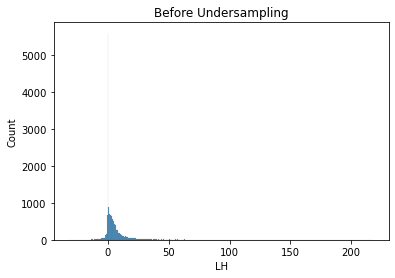

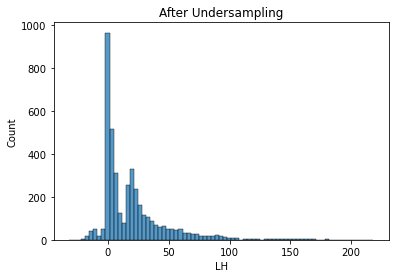

In [479]:
import seaborn as sns
sns.histplot(y)
plt.title("Before Undersampling")
plt.show()
sns.histplot(y_under)
plt.title("After Undersampling")
plt.show()

# NNC - Basic Implementation

In [480]:
# Dataset Definition
class CustomWaveData(Dataset):
    def __init__(self, dataframe, ys):
        self.y = torch.tensor(ys.values,dtype=torch.float32)
        self.x = torch.tensor(dataframe.values,dtype=torch.float32)
        self.size = len(dataframe)
        
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.size

In [481]:
from sklearn.model_selection import train_test_split

# split the data
X_train, X_test, y_train, y_test = train_test_split(X_under, y_extreme_under, test_size=0.2, random_state=42)

training_data = CustomWaveData(X_train,y_train)
test_data = CustomWaveData(X_test, y_test)

train_dataloader = DataLoader(training_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False)
print(len(train_dataloader))
print(len(test_dataloader))

106
27


In [482]:
# define the model -- as of now the same shape of the previous one
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # initialize the sequential/feedforward net here
        self.linear_relu_stack = nn.Sequential(
        
        # input layer,
        nn.Linear(9,9),
        # relu activation
        nn.ReLU(),     
            
        # hidden layer 1
        nn.Linear(9,9),
        nn.ReLU(),
            
        # nn.Dropout(p=.2),    
            
        # hidden layer 2
#         nn.Linear(9,9),
#         nn.ReLU(),
            
#         nn.Dropout(p=.2),    
            
        # hidden layer 3
        # nn.Linear(9,9),
        # nn.ReLU(),    
            
        # output -> we can always play around with the shape of the network
        # I just want to see that this works for now
        nn.Linear(9,1)
        )
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        logits = self.linear_relu_stack(x)
        logits = self.sigmoid(logits)
        return logits

In [483]:
# testing
model = NeuralNetwork()
test_data = training_data[0]
X,y = test_data
print(X)
test_res = model(X)
print(test_res.item())
print(y)

tensor([ 0.4636, -1.8409,  1.3668, -1.1960, -0.5109,  0.2767,  0.5496,  1.0270,
        -0.0476])
0.5629292130470276
tensor(0.)


In [484]:
# defining the loss
# Binary Cross Entropy
loss_fn = nn.BCELoss()

# define the optimization: Adam, lr = learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=.001, weight_decay = .01)

In [485]:
# training loop
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    # define the metrics
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    
    train_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)
        # pred = (pred > .5).float()
        y = y.unsqueeze(1)
        
        # update the metrics needed for evaluation
        cm = confusion_matrix(y, (pred > .5).float())
        tp += cm[1][1]
        fp += cm[0][1]
        tn += cm[0][0]
        fn += cm[1][0]
            
        loss = loss_fn(pred,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() 
        
        # train_losses.append(loss.item())
        train_loss += loss.item()
        
        # if batch % 100 == 0:
        #     loss, current = loss.item(), (batch + 1) * len(X)
        #     print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    # used for testing:  
    # print(f"Train Size: {size}")
    # print(f"Train correct: {tp+tn}")
    # print(f"Train fp: {fp}")
    # print(f"Train fn: {fn}")
    # print(f"Train Acc: {(tp + tn) /size}")
    train_avg_loss = train_loss/size
    train_f1 = (2*tp) / ((2*tp) + fp + fn)
    # print(f"Train f1: {train_f1}")
    return train_f1, train_avg_loss

In [486]:
# test loop
def test(dataloader, model, loss_fn):
    # size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    # define the metrics
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    with torch.no_grad():
        for X, y in (dataloader):
            # get the preds and true
            pred = model(X)
            # pred = (pred > .5).float()
            y = y.unsqueeze(1)
                            
            # update the metrics needed for evaluation
            cm = confusion_matrix(y, (pred > .5).float())
            tp += cm[1][1]
            fp += cm[0][1]
            tn += cm[0][0]
            fn += cm[1][0]

            
            test_loss += loss_fn(pred, y).item()
            # correct += (((pred > .5) * 1) == y).sum()
    # print(f"Test correct: {tp+tn}")
    # print(f"Test fp: {fp}")
    # print(f"Test fn: {fn}")        
    # print(f"Test Avg Loss: {test_loss/num_batches}, Test Acc: {(tp+tn)/len(dataloader.dataset)}")
    test_avg_loss = test_loss/num_batches
    # print(f"Test Acc.: {(tp+tn)/(tp+fp+tn+fn)}")
    test_f1 = (2*tp) / ((2*tp) + fp + fn)
    # print(f"Test f1: {test_f1}")
    return test_f1, test_avg_loss

## Test and Train

In [487]:
epochs = 30
train_f1 = 0
test_f1 = 0
tal = 0
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    # train_f1.append(train(train_dataloader, model, loss_fn, optimizer))
    train_f1, tr_al = train(train_dataloader, model, loss_fn, optimizer)
    # test_f1.append(test(test_dataloader, model, loss_fn))
    test_f1, tal = test(test_dataloader, model, loss_fn)
    # print(f"Best Train f1: {max(train_)}")
    # print(f"Best Test f1: {max(test_f1)}")

print(f" Train f1: {train_f1}")
print(f" Train Loss: {tr_al}")
print(f" Test f1: {test_f1}")
print(f" Test Loss: {tal}")
print("Done!")

Epoch 1
-------------------------------
Epoch 2
-------------------------------
Epoch 3
-------------------------------
Epoch 4
-------------------------------
Epoch 5
-------------------------------
Epoch 6
-------------------------------
Epoch 7
-------------------------------
Epoch 8
-------------------------------
Epoch 9
-------------------------------
Epoch 10
-------------------------------
Epoch 11
-------------------------------
Epoch 12
-------------------------------
Epoch 13
-------------------------------
Epoch 14
-------------------------------
Epoch 15
-------------------------------
Epoch 16
-------------------------------
Epoch 17
-------------------------------
Epoch 18
-------------------------------
Epoch 19
-------------------------------
Epoch 20
-------------------------------
Epoch 21
-------------------------------
Epoch 22
-------------------------------
Epoch 23
-------------------------------
Epoch 24
-------------------------------
Epoch 25
----------------

# Testing With Different Model Shapes

In [488]:
# first I should redefine the data loaders and make two versions of them:
# 1) All Features
# 2) The Selected Features

# same method as above
# Reread the data and make two versions:
data_850 = pd.read_csv('NA850data_2000-2014.csv')
data_w_extreme = add_extreme(data_850)

# get scaled provided data with deltas and time added
X = data_850.drop(columns=['LH'])
X = add_deltas_and_time(X)
X = scale_data(X)

y = data_850['LH']
y_extreme = data_w_extreme['Extreme']

selected_features = ["AirTemp", "QV", "Omega", "VWinds", "UWinds",
                     "dOmega", "Lat","WaveTrajectory", "PtIndex"]

X_select = X[selected_features]
X.head()

,AirTemp,QV,Omega,SeaLevPress,UWinds,VWinds,Lat,Lon,PtIndex,WaveTrajectory,dAirTemp,dQV,dOmega,dSeaLevPress,dUWinds,dVWinds,dLat,dLon,dPtIndex,dWaveTrajectory
Time,,,,,,,,,,,,,,,,,,,,
2000-01-01 00:00:00,-5.894685,-0.921917,0.663327,2.255124,-0.838782,-1.512121,1.284264,0.046455,-0.904762,-1.252252,0.023965,-0.020884,0.001439,-0.031599,0.008588,-0.019885,-0.051313,1.086233,-1.0,0.0
2000-01-03 06:00:00,-3.680371,-0.425460,-0.022623,0.672601,-1.048340,-0.713308,0.730487,-0.914611,-0.047619,-1.252252,6.670923,2.258245,-0.935016,-2.753314,-0.637262,1.909090,-9.334594,-31.353357,17.0,0.0
2000-01-01 03:00:00,-5.871791,-0.875048,0.071067,2.125345,-0.711381,-0.966044,1.214122,-0.022959,-0.857143,-1.252252,-6.554269,-2.084847,0.129345,2.466917,1.047082,-0.630193,8.056147,31.182853,-18.0,0.0
2000-01-03 09:00:00,-3.512013,-0.464887,0.337309,0.527725,-0.801232,-0.684463,0.612075,-0.959157,0.000000,-1.252252,7.107577,1.862080,0.364911,-2.779281,-0.268328,0.660079,-10.143794,-30.513986,17.0,0.0
2000-01-01 06:00:00,-5.890387,-0.906401,0.462108,1.914790,-0.522681,-0.659917,1.234360,-0.077947,-0.809524,-1.252252,-7.115468,-2.047782,0.171814,2.353958,0.867068,0.039388,10.380425,30.830375,-18.0,0.0


In [489]:
X_select.head()

,AirTemp,QV,Omega,VWinds,UWinds,dOmega,Lat,WaveTrajectory,PtIndex
Time,,,,,,,,,
2000-01-01 00:00:00,-5.894685,-0.921917,0.663327,-1.512121,-0.838782,0.001439,1.284264,-1.252252,-0.904762
2000-01-03 06:00:00,-3.680371,-0.425460,-0.022623,-0.713308,-1.048340,-0.935016,0.730487,-1.252252,-0.047619
2000-01-01 03:00:00,-5.871791,-0.875048,0.071067,-0.966044,-0.711381,0.129345,1.214122,-1.252252,-0.857143
2000-01-03 09:00:00,-3.512013,-0.464887,0.337309,-0.684463,-0.801232,0.364911,0.612075,-1.252252,0.000000
2000-01-01 06:00:00,-5.890387,-0.906401,0.462108,-0.659917,-0.522681,0.171814,1.234360,-1.252252,-0.809524


In [490]:
undersampler = RandomUnderSampler(sampling_strategy=1)
X_under, y_extreme_under = undersampler.fit_resample(X, y_extreme)
y_under = y[undersampler.sample_indices_]

X_under_select, y_extreme_under_select = undersampler.fit_resample(X_select, y_extreme)


In [491]:
# testing the views

In [492]:
# creating the data sets (data loaders)

# split the data -- this will be the all data
X_train, X_test, y_train, y_test = train_test_split(X_under, y_extreme_under, test_size=0.2, random_state=42)

# make them custom data classes
training_data = CustomWaveData(X_train,y_train)
test_data = CustomWaveData(X_test, y_test)

# create the all-data loaders
train_dataloader_all = DataLoader(training_data, batch_size=32, shuffle=True)
test_dataloader_all = DataLoader(test_data, batch_size=32, shuffle=False)

# now for the selected data
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_under_select, y_extreme_under_select, test_size=0.2, random_state=42)

# make them custom data classes
training_data_s = CustomWaveData(X_train_s, y_train_s)
test_data_s = CustomWaveData(X_test_s, y_test_s)

# create the select data loaders
train_dataloader_s = DataLoader(training_data_s, batch_size=32, shuffle=True)
test_dataloader_s = DataLoader(test_data_s, batch_size=32, shuffle=False)

### Define the New NN Models to test

In [493]:
# Start Basic, move to deeper and deeper models

# ================================================ Model 1 ===============================================================================
class NN_1(nn.Module):
    def __init__(self, size):
        super().__init__()
        # initialize the sequential/feedforward net here
        self.linear_relu_stack = nn.Sequential(
        
        # input layer,
        nn.Linear(size,size),
        # relu activation
        nn.ReLU(),     
            
        # output 
        nn.Linear(size,1)
        )
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        logits = self.linear_relu_stack(x)
        logits = self.sigmoid(logits)
        return logits
# ============================================================================================================================================

# ================================================ Model 2 ===============================================================================
class NN_2(nn.Module):
    def __init__(self, size):
        super().__init__()
        # initialize the sequential/feedforward net here
        self.linear_relu_stack = nn.Sequential(
        
        # input layer,
        nn.Linear(size,size),
        # relu activation
        nn.ReLU(),
            
        # hidden layer 1    
        nn.Linear(size,size),
        # relu activation
        nn.ReLU(),
            
        # output 
        nn.Linear(size,1)
        )
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        logits = self.linear_relu_stack(x)
        logits = self.sigmoid(logits)
        return logits    
# ============================================================================================================================================

# ================================================ Model 3 ===============================================================================
class NN_3(nn.Module):
    def __init__(self, size):
        super().__init__()
        # initialize the sequential/feedforward net here
        self.linear_relu_stack = nn.Sequential(
        
        # input layer,
        nn.Linear(size,size),
        # relu activation
        nn.ReLU(),
            
        # hidden layer 1    
        nn.Linear(size,size),
        # relu activation
        nn.ReLU(),
            
        # hidden layer 2    
        nn.Linear(size,size),
        # relu activation
        nn.ReLU(),    
            
        # output 
        nn.Linear(size,1)
        )
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        logits = self.linear_relu_stack(x)
        logits = self.sigmoid(logits)
        return logits
# ============================================================================================================================================

# ================================================ Model 4 ===============================================================================
class NN_4(nn.Module):
    def __init__(self, size):
        super().__init__()
        # initialize the sequential/feedforward net here
        self.linear_relu_stack = nn.Sequential(
        
        # input layer,
        nn.Linear(size,size),
        # relu activation
        nn.ReLU(),
            
        # hidden layer 1    
        nn.Linear(size,size),
        # relu activation
        nn.ReLU(),
            
        # hidden layer 2    
        nn.Linear(size,size),
        # relu activation
        nn.ReLU(),  
            
        # now introduce dropout    
        nn.Dropout(p=.2),    
            
        # hidden layer 3    
        nn.Linear(size,size),
        # relu activation
        nn.ReLU(),    
            
        # output 
        nn.Linear(size,1)
        )
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        logits = self.linear_relu_stack(x)
        logits = self.sigmoid(logits)
        return logits
# ============================================================================================================================================

# ================================================ Model 5 ===============================================================================
class NN_5(nn.Module):
    def __init__(self, size):
        super().__init__()
        # initialize the sequential/feedforward net here
        self.linear_relu_stack = nn.Sequential(
        
        # input layer,
        nn.Linear(size,size),
        # relu activation
        nn.ReLU(),
            
        # hidden layer 1    
        nn.Linear(size,size),
        # relu activation
        nn.ReLU(),
            
        # hidden layer 2    
        nn.Linear(size,size),
        # relu activation
        nn.ReLU(),  
            
        # now introduce dropout    
        nn.Dropout(p=.2),    
            
        # hidden layer 3    
        nn.Linear(size,size),
        # relu activation
        nn.ReLU(), 
            
        # hidden layer 4    
        nn.Linear(size,size),
        # relu activation
        nn.ReLU(),    
            
        # output 
        nn.Linear(size,1)
        )
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        logits = self.linear_relu_stack(x)
        logits = self.sigmoid(logits)
        return logits
# ============================================================================================================================================

# ================================================ Model 6 ===============================================================================
class NN_5(nn.Module):
    def __init__(self, size):
        super().__init__()
        # initialize the sequential/feedforward net here
        self.linear_relu_stack = nn.Sequential(
        
        # input layer,
        nn.Linear(size,size),
        # relu activation
        nn.ReLU(),
            
        # hidden layer 1    
        nn.Linear(size,size),
        # relu activation
        nn.ReLU(),
            
        # now introduce dropout    
        nn.Dropout(p=.2),    
            
        # hidden layer 2    
        nn.Linear(size,size),
        # relu activation
        nn.ReLU(),  
            
        # now introduce dropout    
        nn.Dropout(p=.2),    
            
        # hidden layer 3    
        nn.Linear(size,size),
        # relu activation
        nn.ReLU(), 
            
        # hidden layer 4    
        nn.Linear(size,size),
        # relu activation
        nn.ReLU(),   
           
        # now introduce dropout    
        nn.Dropout(p=.2),    
            
        # hidden layer 5    
        nn.Linear(size,size),
        # relu activation
        nn.ReLU(),    
            
        # output 
        nn.Linear(size,1)
        )
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        logits = self.linear_relu_stack(x)
        logits = self.sigmoid(logits)
        return logits
# ===========================================================================================================================================

# ================================================ Model 7 ===============================================================================
class NN_6(nn.Module):
    def __init__(self, size):
        super().__init__()
        # initialize the sequential/feedforward net here
        self.linear_relu_stack = nn.Sequential(
        
        # input layer,
        nn.Linear(size,size),
        # relu activation
        nn.ReLU(),
            
        # hidden layer 0    
        nn.Linear(size,size),
        # relu activation
        nn.ReLU(),
            
        # now introduce dropout    
        nn.Dropout(p=.2),    
            
        # hidden layer 1    
        nn.Linear(size,size),
        # relu activation
        nn.ReLU(),
            
        # now introduce dropout    
        nn.Dropout(p=.2),    
            
        # hidden layer 2    
        nn.Linear(size,size),
        # relu activation
        nn.ReLU(),  
            
        # now introduce dropout    
        nn.Dropout(p=.2),    
            
        # hidden layer 3    
        nn.Linear(size,size),
        # relu activation
        nn.ReLU(), 
            
        # hidden layer 4    
        nn.Linear(size,size),
        # relu activation
        nn.ReLU(),   
           
        # now introduce dropout    
        nn.Dropout(p=.2),    
            
        # hidden layer 5    
        nn.Linear(size,size),
        # relu activation
        nn.ReLU(),    
            
        # output 
        nn.Linear(size,1)
        )
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        logits = self.linear_relu_stack(x)
        logits = self.sigmoid(logits)
        return logits
# ===========================================================================================================================================

### Testing

In [494]:
# starting with all data
size = 20
# create the models
m1 = NN_1(size)
m2 = NN_2(size)
m3 = NN_3(size)
m4 = NN_4(size)
m5 = NN_5(size)
m6 = NN_6(size)

models_list = [m1,m2,m3,m4,m5,m6]

In [495]:
# Here I will define all the lists needed to keep track - for size = 20
# these will hold the f1's at each epoch for their respective models
m1_f1 = []
m2_f1 = []
m3_f1 = []
m4_f1 = []
m5_f1 = []
m6_f1 = []

# and these will hold the avg test loss per model
m1_tal = []
m2_tal = []
m3_tal = []
m4_tal = []
m5_tal = []
m6_tal = []

### Model testing loop (all data)

In [496]:
# i need some way to keep track of the f1 scores as the epochs occur, so my (quick) plan is to 
# iterate I and check the value inside this model-testing loop - not a great solution, fix if time allows
i = 0
for model_idx in models_list:
    print(f"=====================================\n{model_idx}\n=====================================")
    i += 1
    
    # have these here for quick testing
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model_idx.parameters(), lr=.001, weight_decay = .01)
    
    # init the f1's
    f1s = []
    # inti the tal's
    tals = []
    # the loop
    epochs = 30
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_f1, tr_al = (train(train_dataloader_all, model_idx, loss_fn, optimizer))
        # train(train_dataloader_all, model_idx, loss_fn, optimizer)
        f1, tal = (test(test_dataloader_all, model_idx, loss_fn))
        # test(test_dataloader_all, model_idx, loss_fn)
        f1s.append(f1)
        tals.append(tal)
    # print(f"Best Train f1: {max(train_f1)}")
    print(f" f1s: {(f1s)}")
    print(f" Tals: {tals}")
    # not pretty
    if i == 1:
        m1_f1 = f1s
        m1_tal = tals
    elif i == 2:
        m2_f1 = f1s
        m2_tal = tals
    elif i == 3:
        m3_f1 = f1s
        m3_tal = tals
    elif i == 4:
        m4_f1 = f1s
        m4_tal = tals
    elif i == 5:
        m5_f1 = f1s
        m5_tal = tals
    else:
        m6_f1 = f1s
        m6_tal = tals
    print("Done!")    

NN_1(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=20, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=1, bias=True)
  )
  (sigmoid): Sigmoid()
)
Epoch 1
-------------------------------
Epoch 2
-------------------------------
Epoch 3
-------------------------------
Epoch 4
-------------------------------
Epoch 5
-------------------------------
Epoch 6
-------------------------------
Epoch 7
-------------------------------
Epoch 8
-------------------------------
Epoch 9
-------------------------------
Epoch 10
-------------------------------
Epoch 11
-------------------------------
Epoch 12
-------------------------------
Epoch 13
-------------------------------
Epoch 14
-------------------------------
Epoch 15
-------------------------------
Epoch 16
-------------------------------
Epoch 17
-------------------------------
Epoch 18
-------------------------------
Epoch 19
-------------------------------
Epoch 20
----------------

### Better way of viewing the data

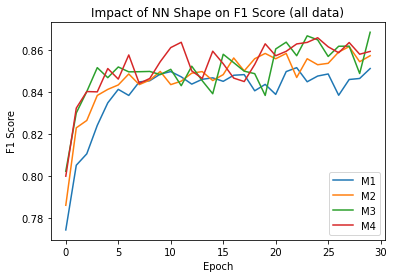

In [497]:
# plot the f1 scores for each model against the number of epochs?

plt.plot(m1_f1, label = "M1")
plt.plot(m2_f1, label = "M2")
plt.plot(m3_f1, label = "M3")
plt.plot(m4_f1, label = "M4")
plt.legend(loc="best")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("Impact of NN Shape on F1 Score (all data)")
plt.show()

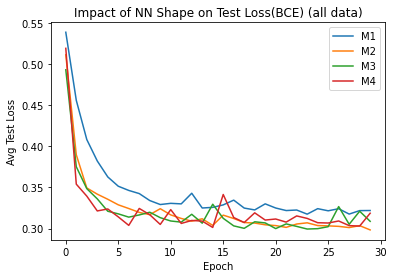

In [498]:
# plot the loss curves
plt.plot(m1_tal, label = "M1")
plt.plot(m2_tal, label = "M2")
plt.plot(m3_tal, label = "M3")
plt.plot(m4_tal, label = "M4")
plt.legend(loc="best")
plt.xlabel("Epoch")
plt.ylabel("Avg Test Loss")
plt.title("Impact of NN Shape on Test Loss(BCE) (all data)")
plt.show()

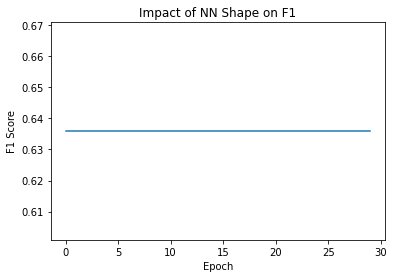

In [499]:
plt.plot(m5_f1, label = "M5")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("Impact of NN Shape on F1")
plt.show()

### Testing with Select Data

In [500]:
# starting with all data
size = 9
# create the models
m1 = NN_1(size)
m2 = NN_2(size)
m3 = NN_3(size)
m4 = NN_4(size)
m5 = NN_5(size)
m6 = NN_6(size)

models_list = [m1,m2,m3,m4,m5,m6]

In [501]:
# Here I will define all the lists needed to keep track - for size = 20
# these will hold the f1's at each epoch for their respective models
m1_f1 = []
m2_f1 = []
m3_f1 = []
m4_f1 = []
m5_f1 = []
m6_f1 = []

# and these will hold the avg test loss per model
m1_tal = []
m2_tal = []
m3_tal = []
m4_tal = []
m5_tal = []
m6_tal = []

### Model Testing Loop (select data)

In [502]:
# i need some way to keep track of the f1 scores as the epochs occur, so my (quick) plan is to 
# iterate I and check the value inside this model-testing loop - not a great solution, fix if time allows
i = 0
for model_idx in models_list:
    print(f"=====================================\n{model_idx}\n=====================================")
    i += 1
    
    # have these here for quick testing
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model_idx.parameters(), lr=.001, weight_decay = .01)
    
    # init the f1's
    f1s = []
    # inti the tal's
    tals = []
    # the loop
    epochs = 30
    for t in range(epochs):
        # print(f"Epoch {t+1}\n-------------------------------")
        train_f1,tr_al = (train(train_dataloader_s, model_idx, loss_fn, optimizer))
        # train(train_dataloader_all, model_idx, loss_fn, optimizer)
        f1, tal = (test(test_dataloader_s, model_idx, loss_fn))
        # test(test_dataloader_all, model_idx, loss_fn)
        f1s.append(f1)
        tals.append(tal)
    # print(f"Best Train f1: {max(train_f1)}")
    print(f" f1s: {(f1s)}")
    print(f" Tals: {tals}")
    # not pretty
    if i == 1:
        m1_f1 = f1s
        m1_tal = tals
    elif i == 2:
        m2_f1 = f1s
        m2_tal = tals
    elif i == 3:
        m3_f1 = f1s
        m3_tal = tals
    elif i == 4:
        m4_f1 = f1s
        m4_tal = tals
    elif i == 5:
        m5_f1 = f1s
        m5_tal = tals
    else:
        m6_f1 = f1s
        m6_tal = tals
    print("Done!")  

NN_1(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=9, out_features=9, bias=True)
    (1): ReLU()
    (2): Linear(in_features=9, out_features=1, bias=True)
  )
  (sigmoid): Sigmoid()
)
 f1s: [0.7252252252252253, 0.7555555555555555, 0.7870813397129187, 0.7937273823884198, 0.8053855569155447, 0.8239700374531835, 0.8387909319899244, 0.8443877551020408, 0.8461538461538461, 0.8512820512820513, 0.8516624040920716, 0.8512820512820513, 0.8534704370179949, 0.8487928843710292, 0.8589743589743589, 0.8538754764930114, 0.8564036222509702, 0.8534704370179949, 0.8538163001293662, 0.8520408163265306, 0.8508997429305912, 0.851994851994852, 0.8505747126436781, 0.8487179487179487, 0.8527131782945736, 0.8505154639175257, 0.8490322580645161, 0.8541935483870968, 0.8461538461538461, 0.8505154639175257]
 Tals: [0.5826921518202182, 0.5152055014062811, 0.4653947044301916, 0.4306975271966722, 0.40559596927077685, 0.38799199020421066, 0.37549752052183505, 0.36815458812095503, 0.363601706094212, 0

### View the select data

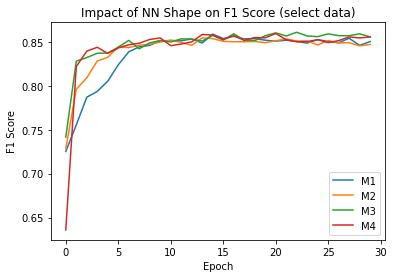

In [503]:
# plot the f1 scores for each model against the number of epochs?

plt.plot(m1_f1, label = "M1")
plt.plot(m2_f1, label = "M2")
plt.plot(m3_f1, label = "M3")
plt.plot(m4_f1, label = "M4")
plt.legend(loc="best")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("Impact of NN Shape on F1 Score (select data)")
plt.show()

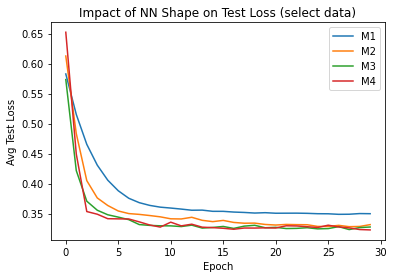

In [504]:
# plot the loss curves
plt.plot(m1_tal, label = "M1")
plt.plot(m2_tal, label = "M2")
plt.plot(m3_tal, label = "M3")
plt.plot(m4_tal, label = "M4")
plt.legend(loc="best")
plt.xlabel("Epoch")
plt.ylabel("Avg Test Loss")
plt.title("Impact of NN Shape on Test Loss (select data)")
plt.show()